##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2.57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

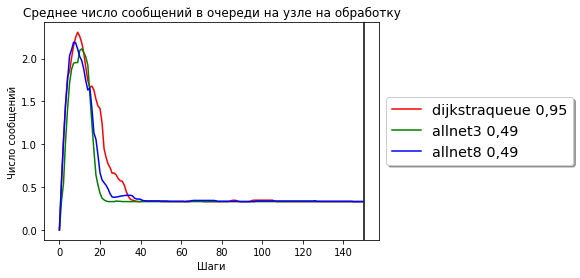

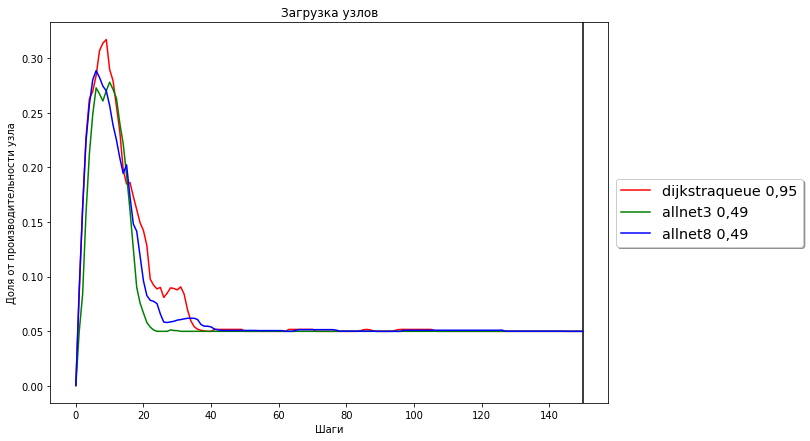

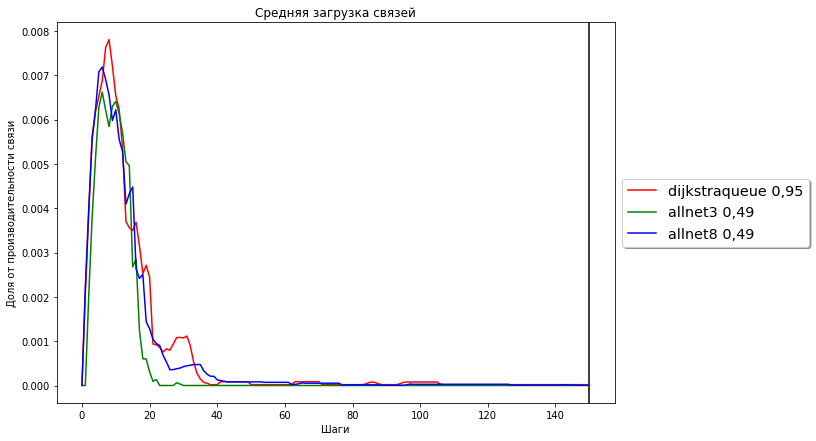

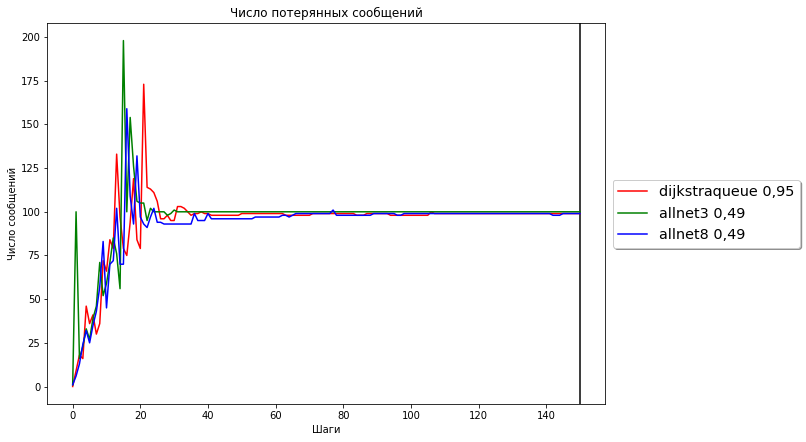

Доставлено 750 Потеряно 95.0003% -dijkstraqueue 0,95
Доставлено 457 Потеряно 96.9535% -allnet3 0,49
Доставлено 956 Потеряно 93.6271% -allnet8 0,49


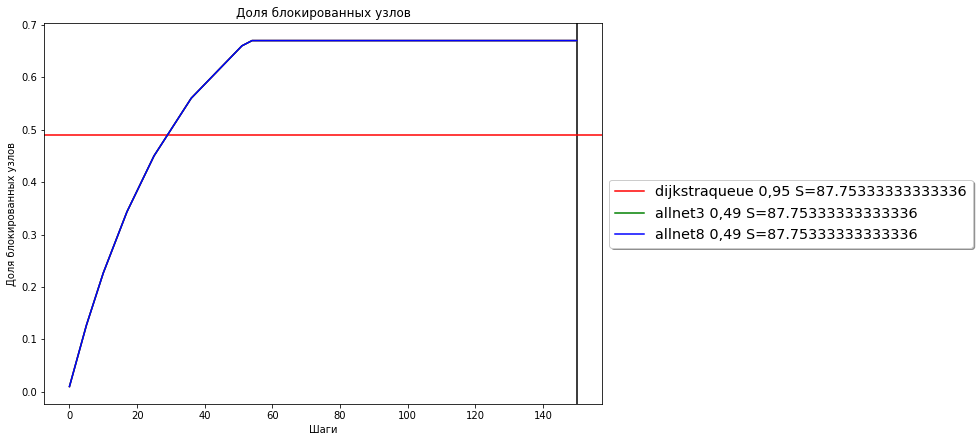

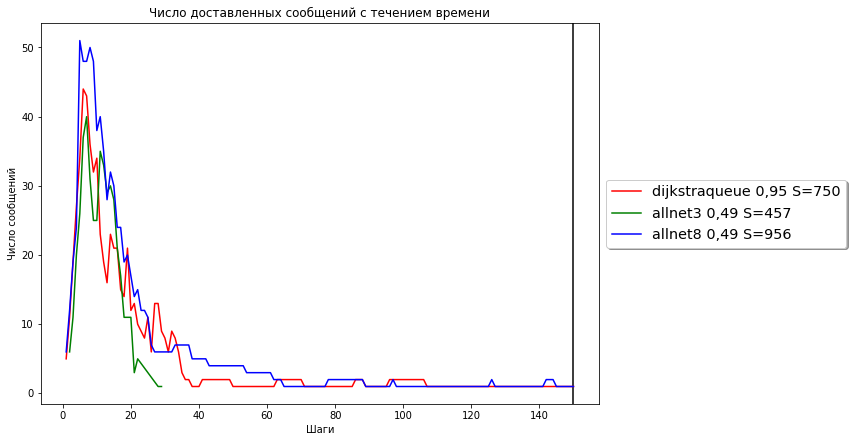

In [2]:
quantity = 100;
log_tags = [
{"tag":  "c46365eb-3314-43a9-b68f-c05e529f9d2e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a15778b4-ee40-4901-b304-42847cf22a05", "label": "allnet3 0,49", "color": "green"},
{"tag":  "d540a3a0-2461-4ba9-9eb7-42b698732841", "label": "allnet8 0,49", "color": "blue"},

]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

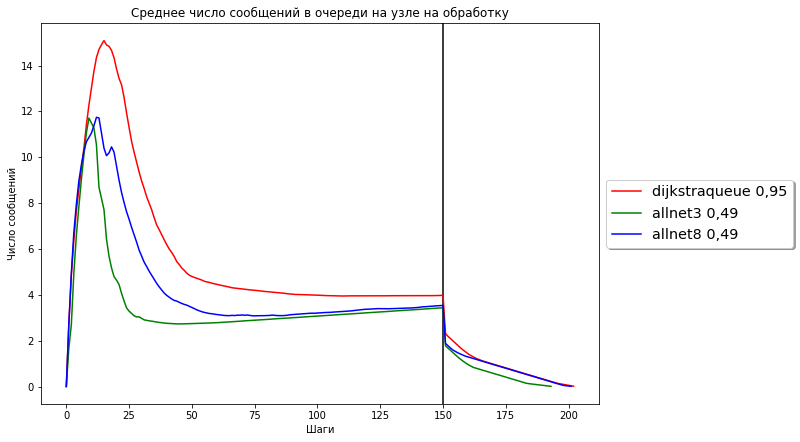

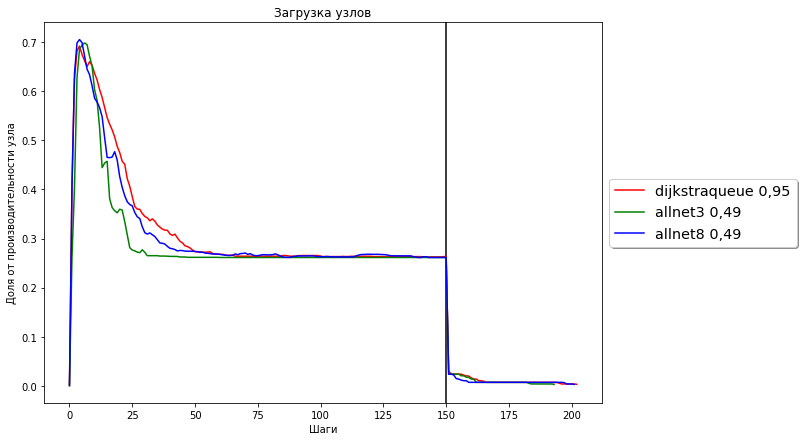

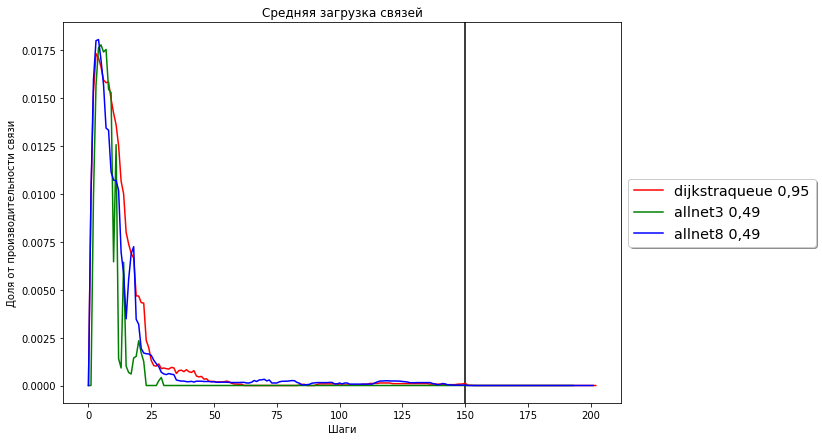

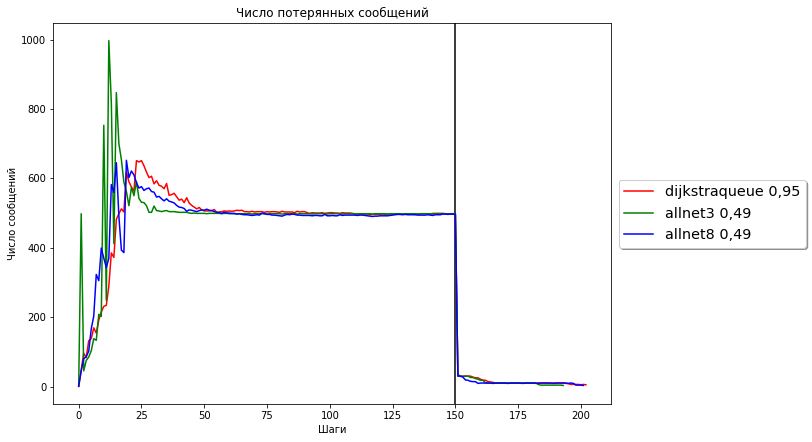

Доставлено 1302 Потеряно 98.2640% -dijkstraqueue 0,95
Доставлено 677 Потеряно 99.0973% -allnet3 0,49
Доставлено 1592 Потеряно 97.8774% -allnet8 0,49


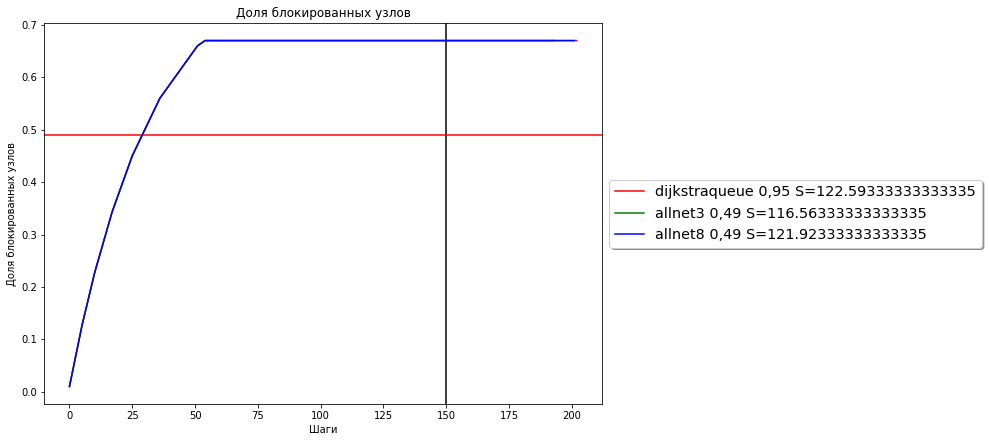

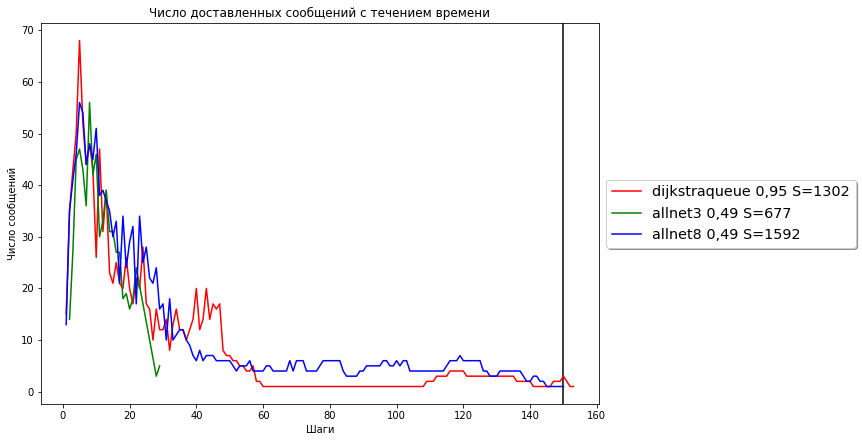

In [3]:
quantity = 500;
log_tags = [
{"tag":  "814e7cdd-af93-4df1-8d29-f860071ac298", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "bb8ce49a-974b-4d19-9ec9-b88321abda80", "label": "allnet3 0,49", "color": "green"},
{"tag":  "ce733d70-4749-415f-8e39-f56f3cda058a", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

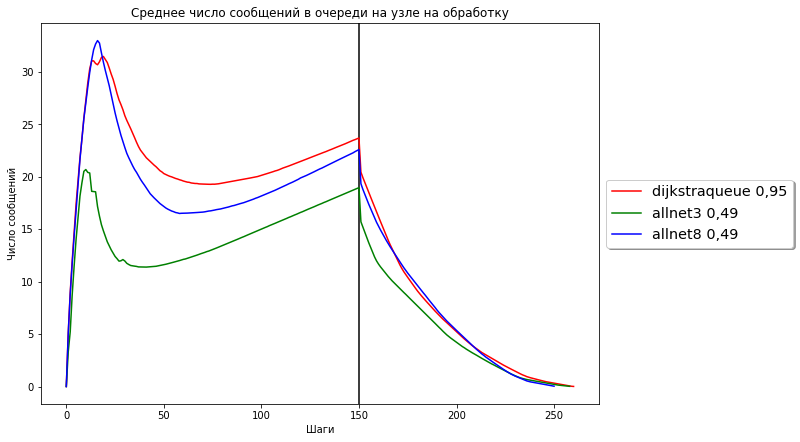

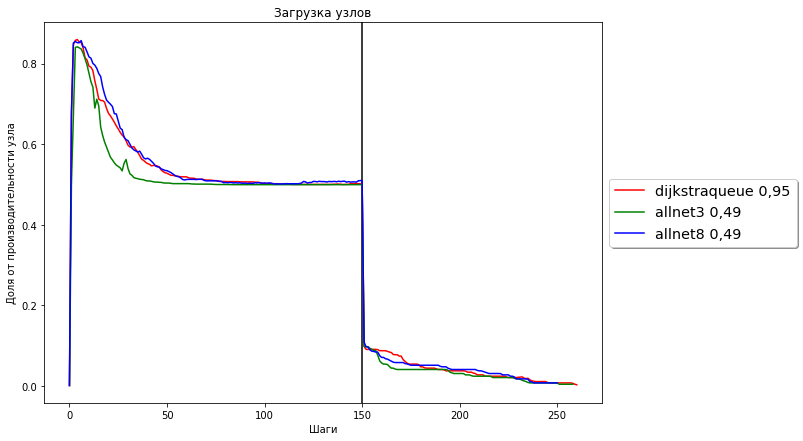

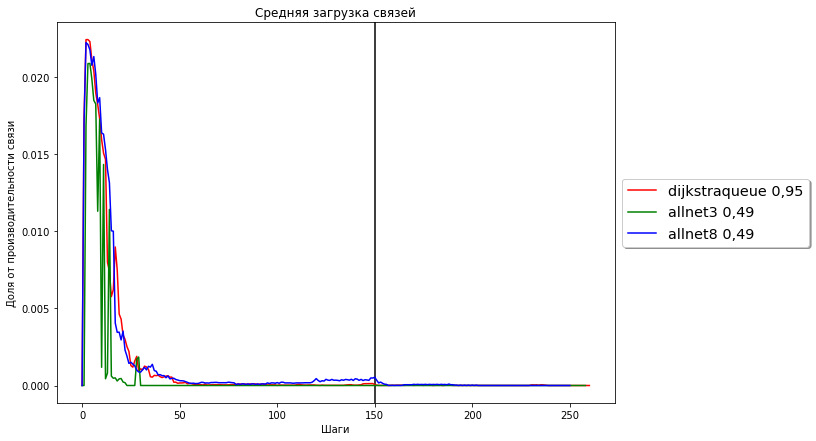

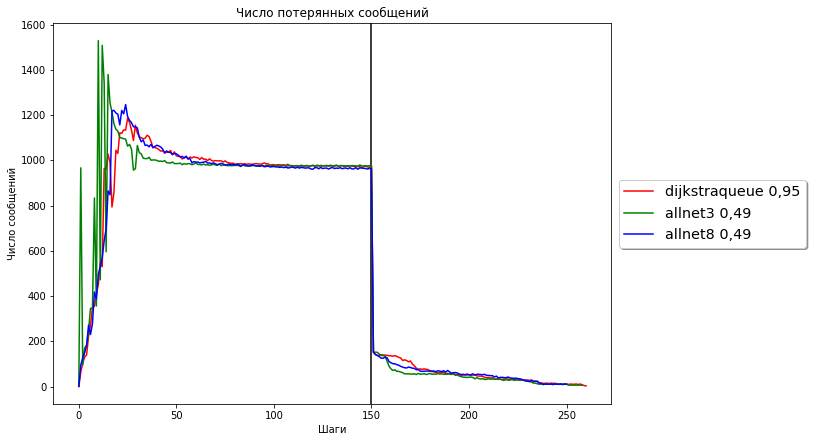

Доставлено 1543 Потеряно 98.9713% -dijkstraqueue 0,95
Доставлено 642 Потеряно 99.5720% -allnet3 0,49
Доставлено 2087 Потеряно 98.6087% -allnet8 0,49


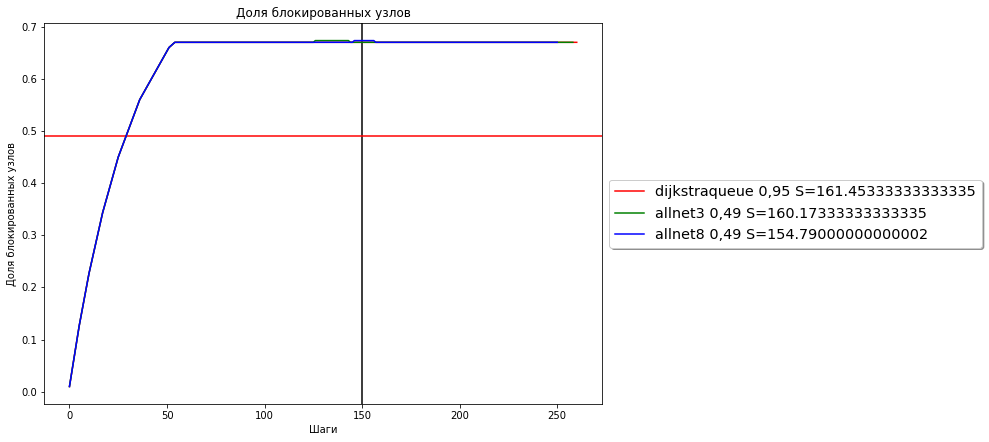

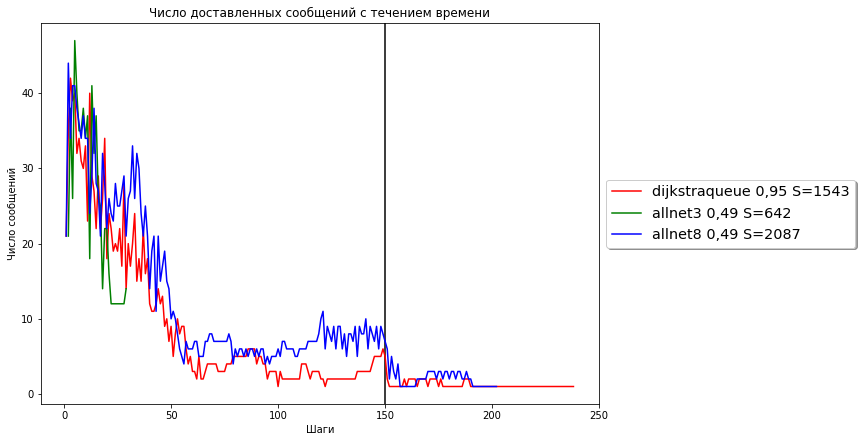

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "7c2d349c-a589-41e1-8c1e-ceb71dff3d38", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8ade6c5f-668d-4cc0-bfa9-27cc8024a4b9", "label": "allnet3 0,49", "color": "green"},
{"tag":  "330ca302-8911-43dd-9404-4d9584a61e79", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

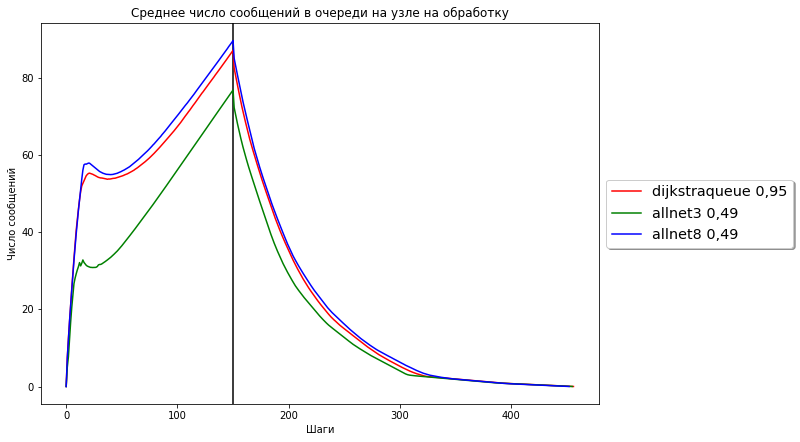

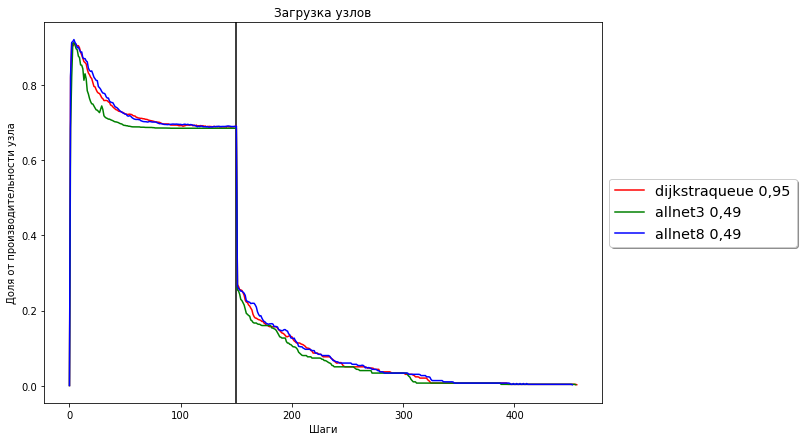

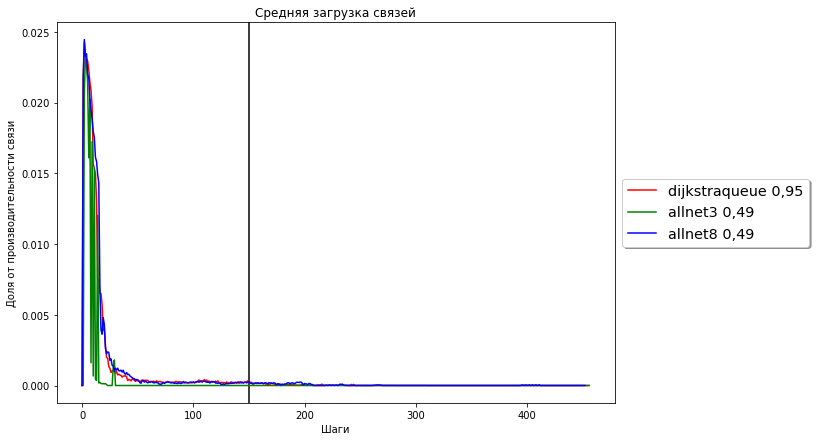

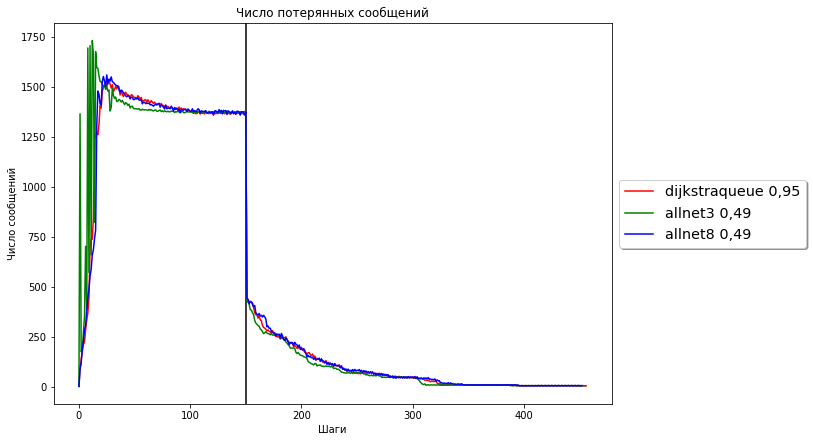

Доставлено 2489 Потеряно 98.8938% -dijkstraqueue 0,95
Доставлено 455 Потеряно 99.7978% -allnet3 0,49
Доставлено 2157 Потеряно 99.0413% -allnet8 0,49


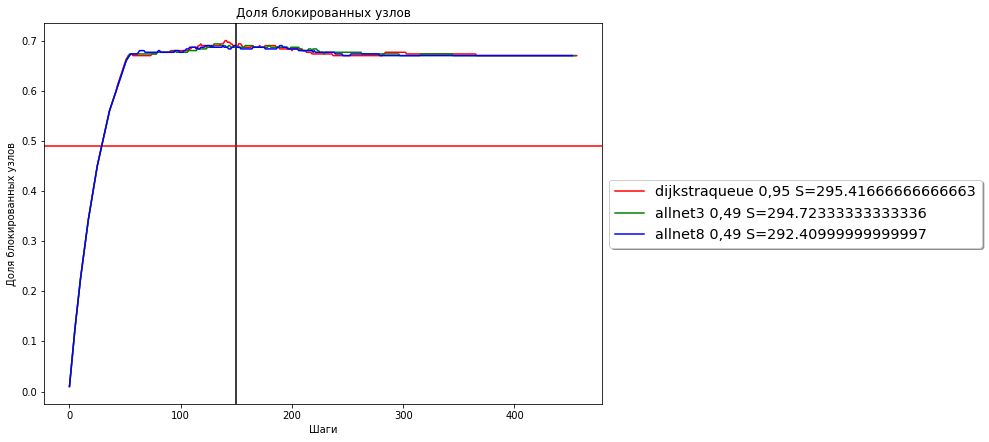

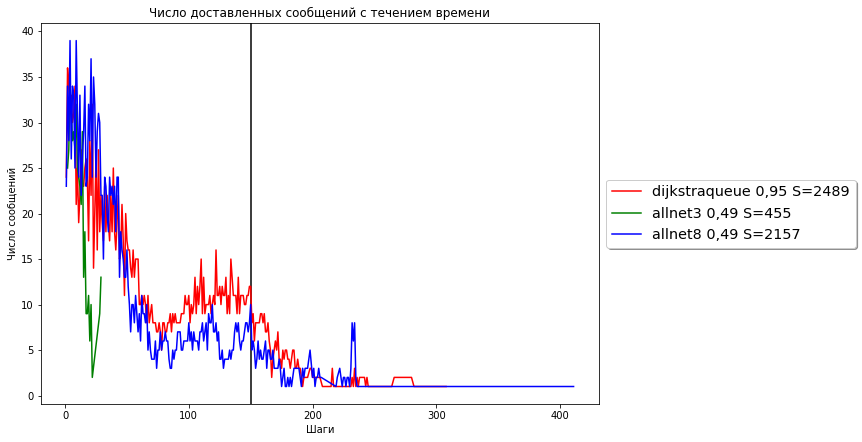

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "0209015c-52ca-476e-92d8-cd05e69b6a7d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "034030b1-9132-43d9-9789-da329c65ef34", "label": "allnet3 0,49", "color": "green"},
{"tag":  "81b29187-0407-450f-afb0-30deac843e23", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 1257 Потеряно 97.2067% -dijkstraqueue 0,95
Доставлено 752 Потеряно 98.3289% -allnet3 0,49
Доставлено 1373 Потеряно 96.9490% -allnet8 0,49


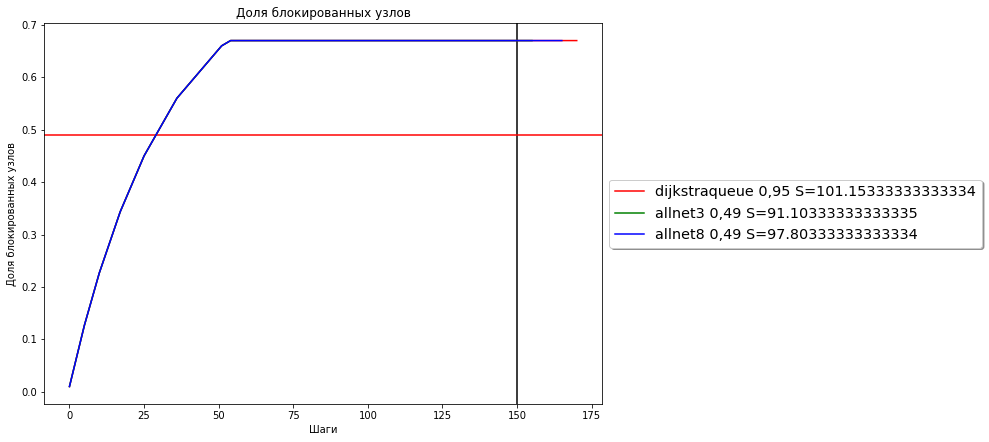

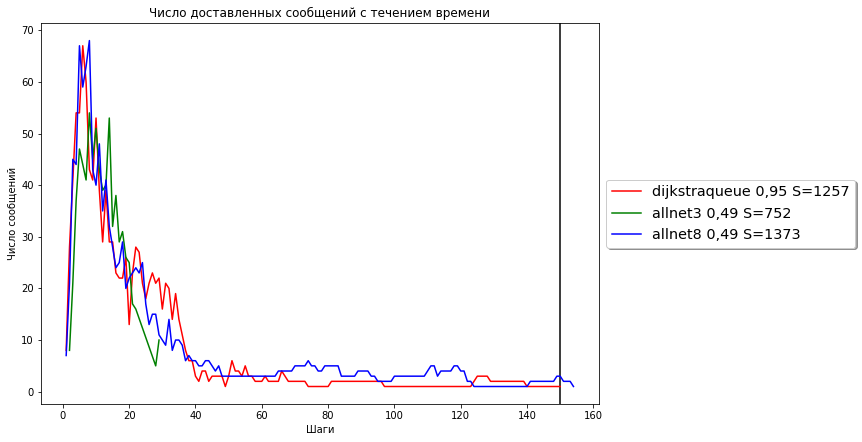

Доставлено 1765 Потеряно 98.3191% -dijkstraqueue 0,95
Доставлено 706 Потеряно 99.3276% -allnet3 0,49
Доставлено 1577 Потеряно 98.4981% -allnet8 0,49


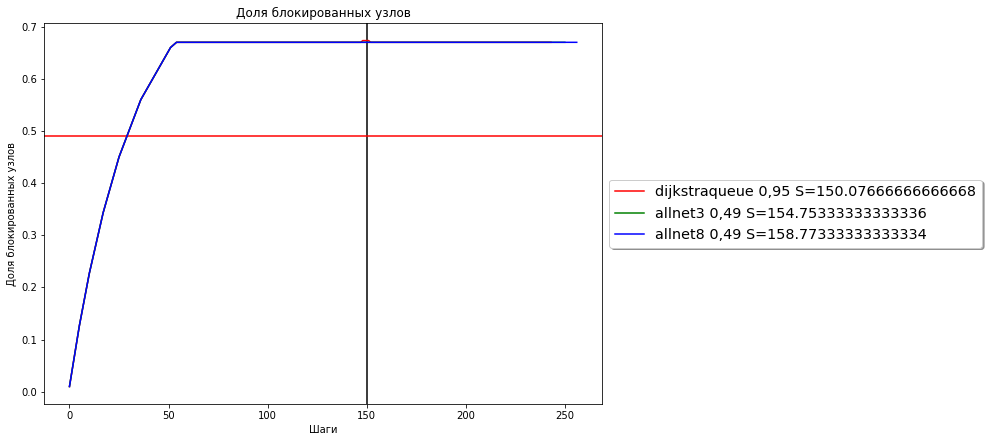

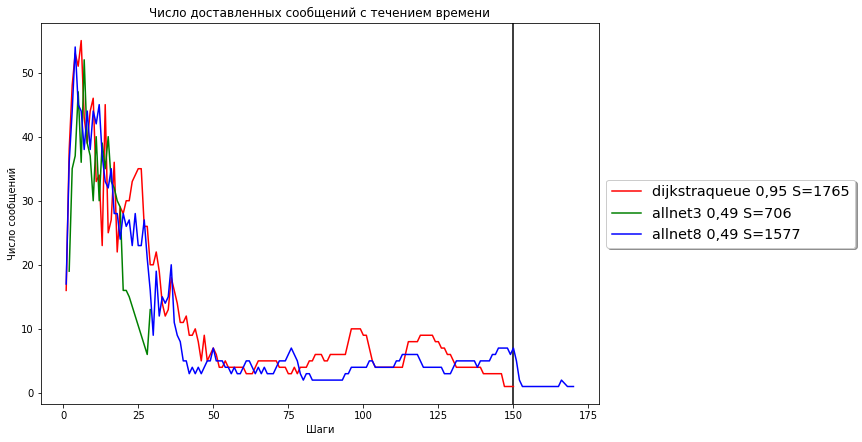

Доставлено 1592 Потеряно 98.8207% -dijkstraqueue 0,95
Доставлено 654 Потеряно 99.5156% -allnet3 0,49
Доставлено 1678 Потеряно 98.7570% -allnet8 0,49


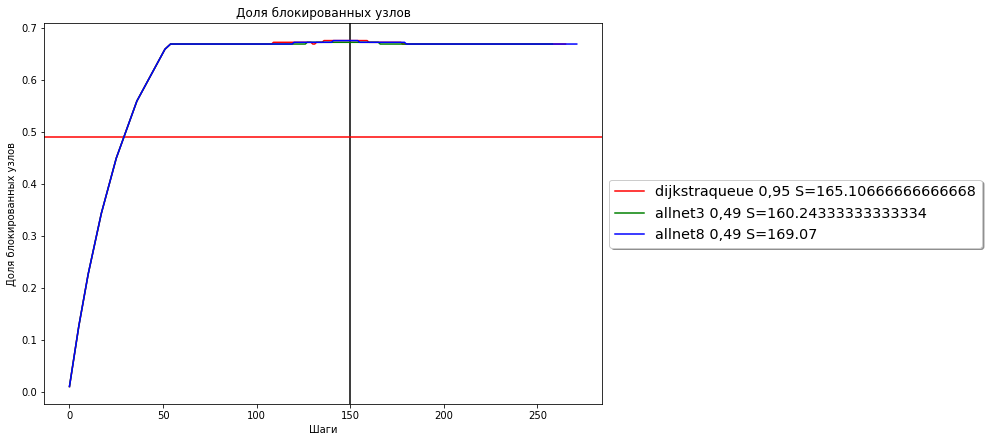

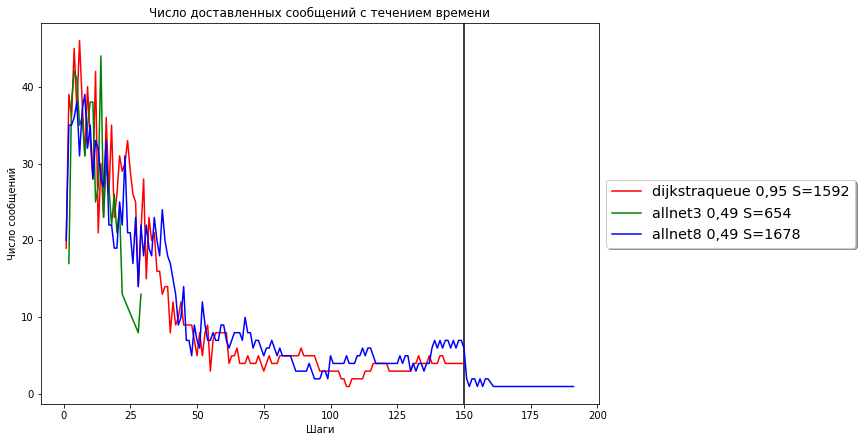

Доставлено 2235 Потеряно 98.8539% -dijkstraqueue 0,95
Доставлено 557 Потеряно 99.7144% -allnet3 0,49
Доставлено 1841 Потеряно 99.0559% -allnet8 0,49


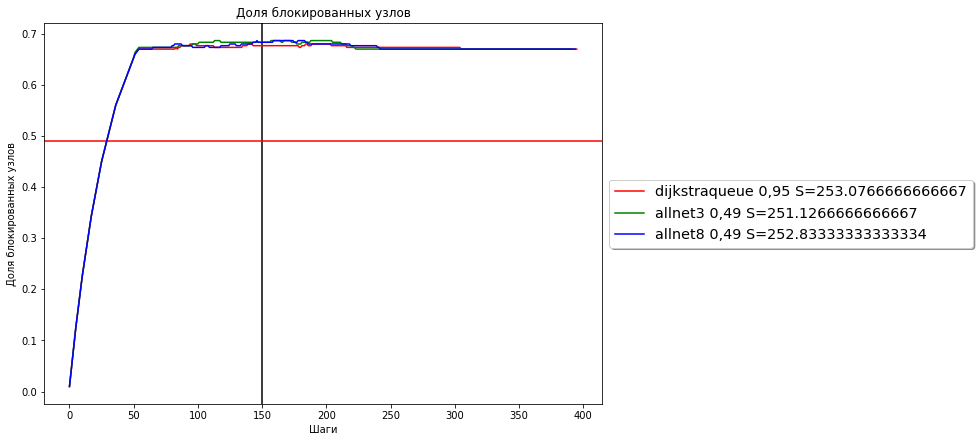

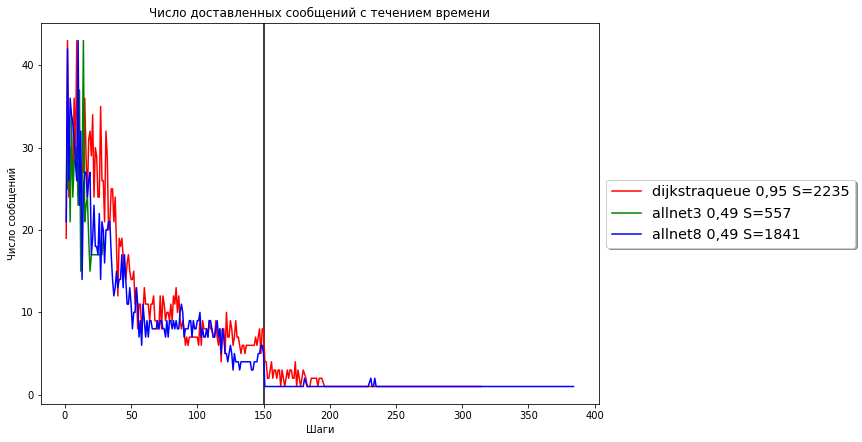

In [6]:
quantity = 300;
log_tags = [
{"tag":  "ed78eb2d-5bdd-4e90-aad4-d5a9c79bcd6b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "6dedc0f9-5e8a-401f-a3ae-d67a3293d16f", "label": "allnet3 0,49", "color": "green"},
{"tag":  "b7f9b614-0919-4b6b-a9a1-ff487d654bdc", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "7d6bdf19-873e-4e18-85c4-94d247c28a5f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "eafbad21-5b5b-412a-b728-b529b4d8e9f1", "label": "allnet3 0,49", "color": "green"},
{"tag":  "3712762f-7356-4542-9b85-b95707dbc0fb", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "6582833e-917e-451f-9602-af4b6ac52e50", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "23f913b0-e447-4db6-957b-cc131cef905d", "label": "allnet3 0,49", "color": "green"},
{"tag":  "854d01b3-f9f5-435b-8f32-7919b48dbb7a", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "e38ecd10-041c-4fc6-959c-477ebb723c11", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8b2e12c7-5312-4d34-861a-f1cc81517682", "label": "allnet3 0,49", "color": "green"},
{"tag":  "94ae7f93-223a-497c-84c1-5d8bcabb06df", "label": "allnet8 0,49", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

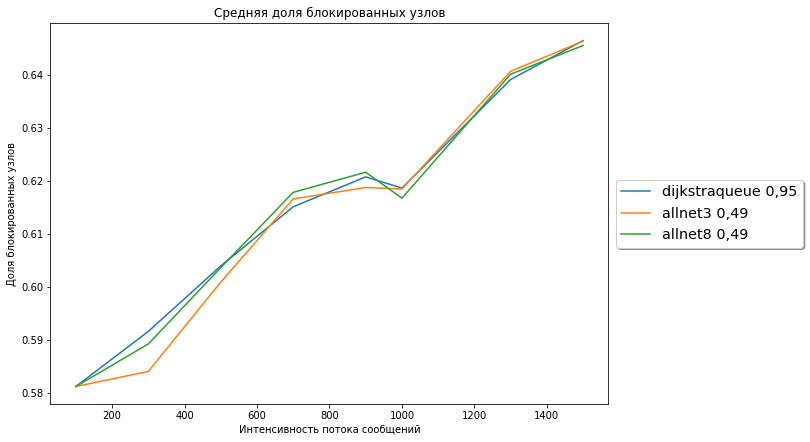

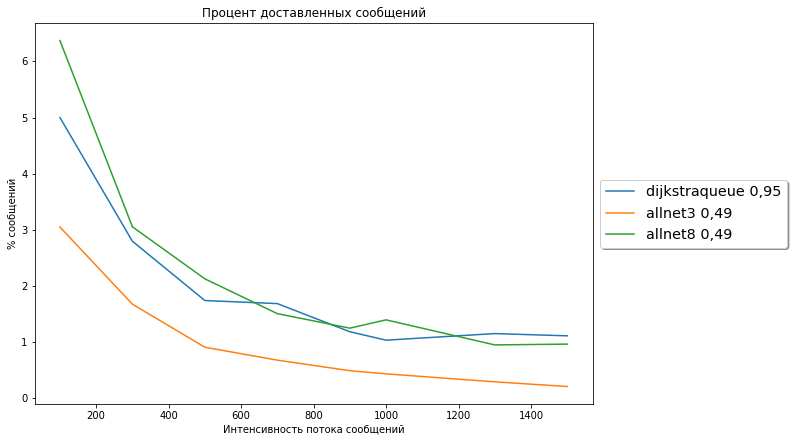

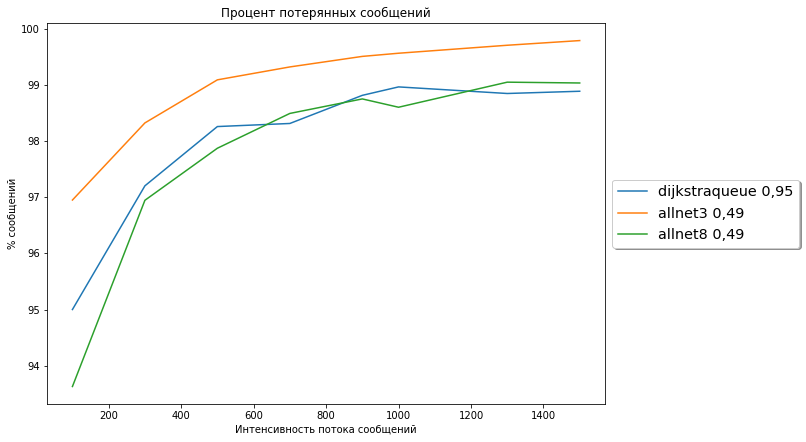

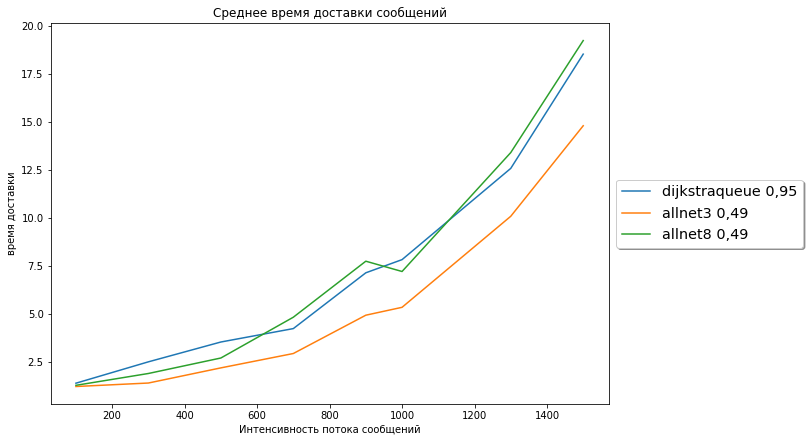

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.614559
allnet3 0,49          0.613327
allnet8 0,49          0.614444

dijkstraqueue 0,95    98.041234
allnet3 0,49          99.038392
allnet8 0,49          97.801810

dijkstraqueue 0,95    7.244859
allnet3 0,49          5.391066
allnet8 0,49          7.314488
